## Accessing Kwando & Upper Zambezi Rivers HydroForecast data

The Planetary Computer's [Kwando & Upper Zambezi Rivers HydroForecast collection](https://planetarycomputer-staging.microsoft.com/dataset/kaza-hydroforecast) includes data on river flow forecasts at six locations in the Kwando and Upper Zambezi river basins.

In [1]:
import pystac_client
import pystac
import planetary_computer
import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import seaborn as sns

### STAC metadata

The `kaza-hydroforecast` collection includes one item per location.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)
collection = catalog.get_collection("kaza-hydroforecast")
items = pystac.ItemCollection(list(collection.get_all_items()))

These STAC items can be loaded into a `geopandas.GeoDataFrame` to plot the locations.

In [3]:
df = geopandas.GeoDataFrame.from_features(items.to_dict()["features"], crs="EPSG:4326")
df[["geometry", "title"]].explore(marker_type="marker")

Each item includes a single asset linking to a Parquet dataset in Azure Blob Storage. As usual, we sign the item to get a read-only SAS token for Blob Storage. See [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [4]:
item = planetary_computer.sign(items[0])
asset = item.assets["data"]

In [5]:
df = pd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df.head()

,initialization_time,valid_time,lead_time_hours,discharge_mean,discharge_median,discharge_q0.01,discharge_q0.025,discharge_q0.05,discharge_q0.1,discharge_q0.25,discharge_q0.5,discharge_q0.75,discharge_q0.9,discharge_q0.95,discharge_q0.975,discharge_q0.99
0,2022-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,0,521.040392,521.202187,518.255239,518.412532,518.794805,519.220917,520.115506,521.202187,521.920834,522.737431,523.195730,523.618969,524.171178
1,2022-01-01 00:00:00+00:00,2022-01-11 00:00:00+00:00,240,688.557286,688.719381,686.103309,686.245598,686.303883,686.522819,687.293951,688.719381,689.357877,690.021671,691.953258,692.449117,692.593963
2,2022-01-01 00:00:00+00:00,2022-01-21 00:00:00+00:00,480,962.331939,962.749783,957.561310,957.744060,958.277032,958.889570,959.842137,962.749783,963.774529,965.275985,966.649766,967.781500,969.343711
3,2022-01-01 00:00:00+00:00,2022-01-31 00:00:00+00:00,720,1234.871588,1234.935563,1227.453010,1228.601463,1228.795023,1230.013754,1232.251886,1234.935563,1237.017182,1240.236123,1240.602200,1241.025181,1243.583617
4,2022-01-01 00:00:00+00:00,2022-02-10 00:00:00+00:00,960,1563.022232,1563.366387,1553.486908,1553.726080,1555.433572,1557.306455,1559.448588,1563.366387,1565.437457,1570.207476,1571.550390,1572.747126,1573.043948


We'll move `initialization_time` and `valid_time` to the index to make it easy to select a subset of the data by time.

In [6]:
df2 = df.set_index(["initialization_time", "valid_time"])

### Plot forecasts

Plot the forecasts out from a specific initialization time:

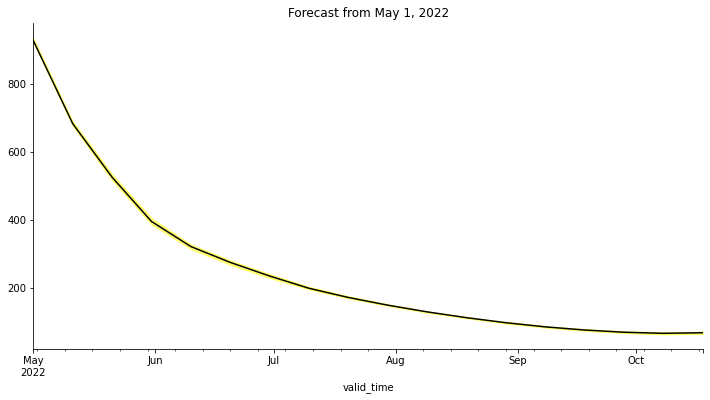

In [7]:
forecasts = df2.loc["2022-05-01"]

fig, ax = plt.subplots(figsize=(12, 6))
ax = forecasts["discharge_mean"].plot(ax=ax, color="black")
ax.fill_between(
    forecasts.index,
    forecasts["discharge_q0.01"],
    forecasts["discharge_q0.99"],
    alpha=0.5,
    color="yellow",
)

ax.set(title="Forecast from May 1, 2022")
sns.despine()

Or we can plot the forecasts leading up to a specific date, to see how the forecast and uncertainty changes as we get closer to the `valid_time`:

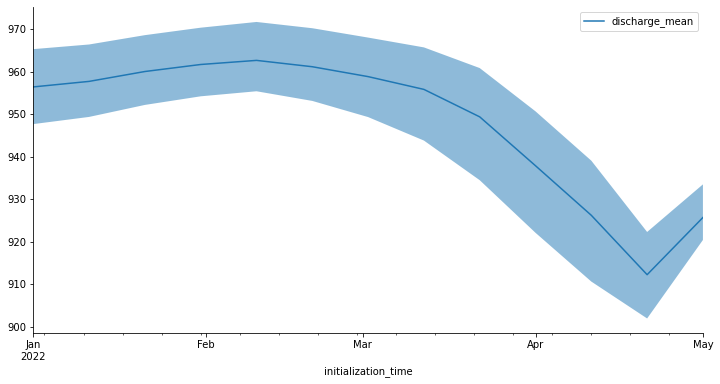

In [8]:
leadup = df2.loc[pd.IndexSlice[:, "2022-05-01"], :].reset_index(level="valid_time")

ax = leadup.plot(y="discharge_mean", figsize=(12, 6))
ax.fill_between(
    leadup.index, leadup["discharge_q0.01"], leadup["discharge_q0.99"], alpha=0.5
)
sns.despine()